<a href="https://colab.research.google.com/github/chuayupeng/cvssV3_Classifier/blob/master/reddragon_cvssv3Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## **CVSSV3 DL-TL Classfier**

The model is supposed to take in a description of a reported vulnerability and output each of the matrices that make up its CVSSV3 base rating.

Data cleaned from NVD, based on all existing vulnerability reports collated.

# Pre-Requisites

First, to check the type of GPU allocated.

In [0]:
!nvidia-smi

Thu Mar 19 07:52:21 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 440.59       Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla P4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   43C    P8     7W /  75W |      0MiB /  7611MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

Downloading the somewhat cleaned data I had previously collated from NVD, and also the glove embedding texts.

In [0]:
!wget https://raw.githubusercontent.com/chuayupeng/cvssV3_Classifier/master/cleanedData.json
!wget -qq https://www.dropbox.com/s/v14xhvjmfniraf3/glove6b100dtxt.zip
# !wget -qq http://nlp.stanford.edu/data/glove.6B.zip
  
!unzip glove6b100dtxt.zip

--2020-03-19 07:52:24--  https://raw.githubusercontent.com/chuayupeng/cvssV3_Classifier/master/cleanedData.json
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 38639694 (37M) [text/plain]
Saving to: ‘cleanedData.json’

cleanedData.json    100%[===================>]  36.85M   169MB/s    in 0.2s    

2020-03-19 07:52:25 (169 MB/s) - ‘cleanedData.json’ saved [38639694/38639694]

Archive:  glove6b100dtxt.zip
  inflating: glove.6B.100d.txt       


Importing relevant libraries

In [0]:
%tensorflow_version 2.x
import sys, os, re, csv, codecs, numpy as np, pandas as pd, tensorflow as tf
import json
import matplotlib.pyplot as plt
%matplotlib inline

TensorFlow 2.x selected.


Building the embedding word vectors.

In [0]:
# first, build index mapping words in the embeddings set
# to their embedding vector

print('Indexing word vectors.')

embeddings_index = {}
with open('glove.6B.100d.txt') as f:
    for line in f:
        values = line.split()
        word = values[0]
        coefs = np.asarray(values[1:], dtype='float32')
        embeddings_index[word] = coefs

print('Found %s word vectors.' % len(embeddings_index))

Indexing word vectors.
Found 400000 word vectors.


# Data Cleaning

In [0]:
cleanDataCSV = {"description": {}, 
                'attackVector': {}, 
                'attackComplexity': {}, 
                'privilegesRequired': {}, 
                'userInteraction': {}, 
                'scope': {}, 
                'confidentialityImpact': {}, 
                'integrityImpact': {}, 
                'availabilityImpact': {}, 
                'baseScore': {}, 
                'baseSeverity': {}}
with open('cleanedData.json', 'r') as infile:
  rawData = json.load(infile)['data']
i = 0
labels = {'NETWORK': 1, 
          'LOCAL': 2, 
          'ADJACENT_NETWORK': 3, 
          'PHYSICAL': 4, 
          'NONE': 5, 
          'LOW': 6, 
          'HIGH': 7, 
          'REQUIRED': 8,
          'UNCHANGED': 9, 
          'CHANGED': 10,
          'CRITICAL':11, 
          'MEDIUM': 12
          }
for data in rawData:
  cleanDataCSV["description"][str(i)] = data['description']
  cleanDataCSV["attackVector"][str(i)] = labels[data['cvssV3']['attackVector']]
  cleanDataCSV["attackComplexity"][str(i)] = labels[data['cvssV3']['attackComplexity']]
  cleanDataCSV["privilegesRequired"][str(i)] = labels[data['cvssV3']['privilegesRequired']]
  cleanDataCSV["userInteraction"][str(i)] = labels[data['cvssV3']['userInteraction']]
  cleanDataCSV["scope"][str(i)] = labels[data['cvssV3']['scope']]
  cleanDataCSV["confidentialityImpact"][str(i)] = labels[data['cvssV3']['confidentialityImpact']]
  cleanDataCSV["integrityImpact"][str(i)] = labels[data['cvssV3']['integrityImpact']]
  cleanDataCSV["availabilityImpact"][str(i)] = labels[data['cvssV3']['availabilityImpact']]
  cleanDataCSV["baseScore"][str(i)] = data['cvssV3']['baseScore']
  cleanDataCSV["baseSeverity"][str(i)] = labels[data['cvssV3']['baseSeverity']]
  i = i + 1

with open('dfCleanedData.json', 'w') as outfile:
  json.dump(cleanDataCSV, outfile)

In [0]:
df = pd.read_json (r'dfCleanedData.json')
export_csv = df.to_csv (r'cleanedData.csv', index = None, header=True)

# Importing Data


In [0]:
data = pd.read_csv('cleanedData.csv')
data.head(5)

,description,attackVector,attackComplexity,privilegesRequired,userInteraction,scope,confidentialityImpact,integrityImpact,availabilityImpact,baseScore,baseSeverity
0,IIS 4.0 and 5.0 allows remote attackers to cau...,1,6,5,5,9,5,5,7,7.5,7
1,crypto/rsa/rsa_gen.c in OpenSSL before 0.9.6 m...,1,6,5,5,9,7,5,5,7.5,7
2,Integer overflow in the new[] operator in gcc ...,2,6,6,5,9,7,7,7,7.8,7
3,Snoopy before 2.0.0 has a security hole in exe...,1,6,5,5,9,7,7,7,9.8,11
4,The redirect_target function in net/ipv4/netfi...,1,6,5,5,9,5,5,7,7.5,7


Sorting inputs and outputs (multiple labels)

In [0]:
X_train = data['description'].str.lower()
list_classes = ["attackVector","attackComplexity","privilegesRequired","userInteraction","scope","confidentialityImpact","integrityImpact","availabilityImpact","baseScore","baseSeverity"]
y = data[list_classes].values
print(X_train[0])
print(y[0])

iis 4.0 and 5.0 allows remote attackers to cause a denial of service by sending many urls with a large number of escaped characters, aka the "myriad escaped characters" vulnerability.
[1.  6.  5.  5.  9.  5.  5.  7.  7.5 7. ]


# Tokenising Input

In [0]:
max_features = 20000
tokenizer = tf.keras.preprocessing.text.Tokenizer(num_words=max_features)
tokenizer.fit_on_texts(list(X_train))
list_tokenized_train = tokenizer.texts_to_sequences(X_train)

Preparing embedding matrix

In [0]:
print('Preparing embedding matrix.')
MAX_SEQUENCE_LENGTH = 200
MAX_NUM_WORDS = 20000
EMBEDDING_DIM = 100
word_index = tokenizer.word_index
# prepare embedding matrix
num_words = min(MAX_NUM_WORDS, len(word_index)) + 1
embedding_matrix = np.zeros((num_words, EMBEDDING_DIM))
for word, i in word_index.items():
    if i > MAX_NUM_WORDS:
        continue
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # words not found in embedding index will be all-zeros.
        embedding_matrix[i] = embedding_vector

# load pre-trained word embeddings into an Embedding layer
# note that we set trainable = False so as to keep the embeddings fixed (Changed to True as accuracy was higher)
embedding_layer = tf.keras.layers.Embedding(num_words,
                            EMBEDDING_DIM,
                            embeddings_initializer=tf.keras.initializers.Constant(embedding_matrix),
                            input_length=MAX_SEQUENCE_LENGTH,
                            trainable=True)

Preparing embedding matrix.


In [0]:
len(word_index)

61835

In [0]:
list_tokenized_train[:1]

[[4306,
  21,
  7,
  5,
  22,
  7,
  15,
  19,
  27,
  2,
  46,
  4,
  51,
  6,
  41,
  34,
  315,
  1454,
  986,
  26,
  4,
  597,
  538,
  6,
  3278,
  783,
  89,
  1,
  3278,
  783,
  9]]

In [0]:
maxlen = 200
X_t = tf.keras.preprocessing.sequence.pad_sequences(list_tokenized_train, maxlen=maxlen)

Choosing 200 for max len due to the plt showing that most of the vuln reports had less than 200 words.

In [0]:
totalNumWords = [len(one_comment) for one_comment in list_tokenized_train]

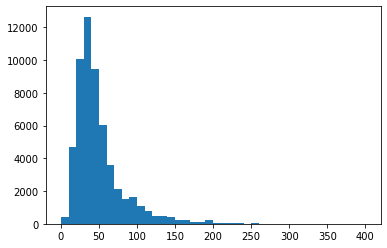

In [0]:
plt.hist(totalNumWords,bins = np.arange(0,410,10))
plt.show()

# Model Building

In [0]:
inp = tf.keras.layers.Input(shape=(maxlen, ))

In [0]:
embed_size = 128
x = embedding_layer(inp)

In [0]:
x = tf.keras.layers.LSTM(512, return_sequences=True,name='lstm_layer')(x)

In [0]:
x = tf.keras.layers.GlobalMaxPool1D()(x)

In [0]:
x = tf.keras.layers.Dense(1024, activation="relu")(x)

In [0]:
x = tf.keras.layers.Dropout(0.1)(x)

In [0]:
x = tf.keras.layers.Dense(512, activation="relu")(x)

In [0]:
x = tf.keras.layers.Dropout(0.2)(x)

In [0]:
x = tf.keras.layers.Dense(256, activation="relu")(x)

In [0]:
x = tf.keras.layers.Dropout(0.3)(x)

In [0]:
x = tf.keras.layers.Dense(128, activation="relu")(x)

In [0]:
x = tf.keras.layers.Dropout(0.1)(x)

In [0]:
x = tf.keras.layers.Dense(64, activation="relu")(x)

In [0]:
x = tf.keras.layers.Dropout(0.2)(x)

In [0]:
x = tf.keras.layers.Dense(32, activation="relu")(x)

In [0]:
x = tf.keras.layers.Dropout(0.5)(x)

In [0]:
x = tf.keras.layers.Dense(10, activation="sigmoid")(x)

In [0]:
model = tf.keras.models.Model(inputs=inp, outputs=x)
model.compile(loss='categorical_crossentropy',
                  optimizer='rmsprop',
                  metrics=['accuracy'])

# Model Training

In [0]:
batch_size = 16
epochs = 3
model.fit(X_t,y, batch_size=batch_size, epochs=epochs, validation_split=0.2)

Train on 45312 samples, validate on 11329 samples
Epoch 1/3
45312/45312 [==============================] - 140s 3ms/sample - loss: 142.1399 - accuracy: 0.7012 - val_loss: 141.4349 - val_accuracy: 0.7224
Epoch 2/3
45312/45312 [==============================] - 136s 3ms/sample - loss: 141.7852 - accuracy: 0.8133 - val_loss: 141.4093 - val_accuracy: 0.7355
Epoch 3/3
45312/45312 [==============================] - 136s 3ms/sample - loss: 141.7484 - accuracy: 0.8356 - val_loss: 141.4132 - val_accuracy: 0.7342


In [0]:
model.summary()

Model: "model_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_9 (InputLayer)         [(None, 200)]             0         
_________________________________________________________________
embedding (Embedding)        (None, 200, 100)          2000100   
_________________________________________________________________
lstm_layer (LSTM)            (None, 200, 512)          1255424   
_________________________________________________________________
global_max_pooling1d_8 (Glob (None, 512)               0         
_________________________________________________________________
dense_46 (Dense)             (None, 1024)              525312    
_________________________________________________________________
dropout_37 (Dropout)         (None, 1024)              0         
_________________________________________________________________
dense_47 (Dense)             (None, 512)               5248